Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


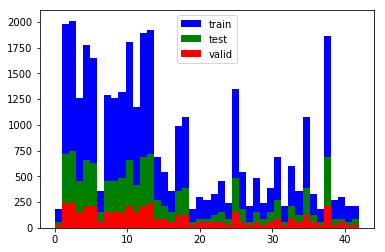

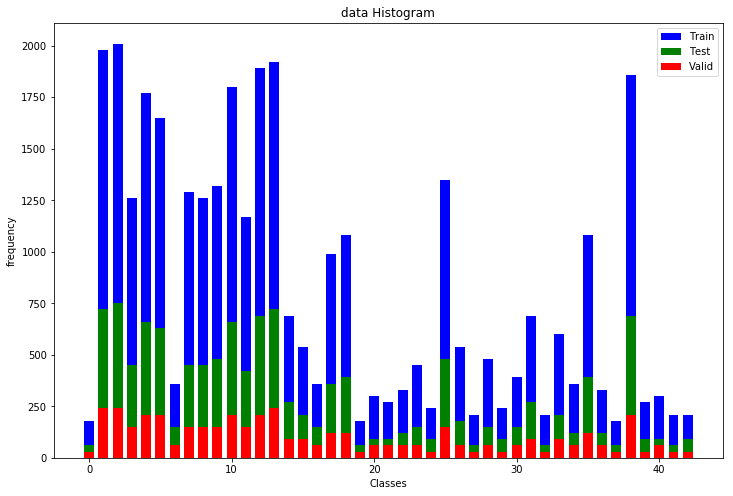

Training...

EPOCH 1 ...
Validation Accuracy = 0.910

EPOCH 2 ...
Validation Accuracy = 0.922

EPOCH 3 ...
Validation Accuracy = 0.939

EPOCH 4 ...
Validation Accuracy = 0.951

EPOCH 5 ...
Validation Accuracy = 0.946

EPOCH 6 ...
Validation Accuracy = 0.951

EPOCH 7 ...
Validation Accuracy = 0.951

EPOCH 8 ...
Validation Accuracy = 0.956

EPOCH 9 ...
Validation Accuracy = 0.956

EPOCH 10 ...
Validation Accuracy = 0.946

EPOCH 11 ...
Validation Accuracy = 0.957

EPOCH 12 ...
Validation Accuracy = 0.960

EPOCH 13 ...
Validation Accuracy = 0.963

EPOCH 14 ...
Validation Accuracy = 0.964

EPOCH 15 ...
Validation Accuracy = 0.963

EPOCH 16 ...
Validation Accuracy = 0.963

EPOCH 17 ...
Validation Accuracy = 0.963

EPOCH 18 ...
Validation Accuracy = 0.964

EPOCH 19 ...
Validation Accuracy = 0.963

EPOCH 20 ...
Validation Accuracy = 0.963

Model saved
INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.952
TopKV2(values=array([[  9.24005091e-01,   4.82024327e-02,   2.47757398e-

In [48]:
import pickle
import csv
import numpy as np
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from skimage import io
import os

# Load pickled data
def loadData(fileName):
    with open(fileName, mode='rb') as f:
        return pickle.load(f)

def loadSeq(fileName):
    seq = loadData(fileName)
    return (seq['features'], seq['labels'])

#Plot the histogram of the training, test and validation data
def plotData(train, test, valid):
    # data to plot
    a = plt.hist(train, bins=n_classes, color='b', label='train')
    b = plt.hist(test, bins=n_classes, color='g', label='test')
    c = plt.hist(valid, bins=n_classes, color='r', label='valid')
 
    # create plot
    index = np.arange(n_classes)
    bar_width = 0.7
    plt.legend()
    plt.figure(figsize=(12,8))
    rects1 = plt.bar(index, a[0], bar_width,
                 color='b',
                 label='Train')
 
    rects2 = plt.bar(index, b[0], bar_width,
                 color='g',
                 label='Test')

    rects3 = plt.bar(index, c[0], bar_width,
                 color='r',
                 label='Valid')
 
    plt.title("data Histogram")
    plt.xlabel("Classes")
    plt.ylabel("frequency")
    plt.legend()
    plt.show()
    
#Print the stats of the test, train and valid data
def printDataStats():
    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)
    plotData(y_train, y_test, y_valid)

#Apply adaptive histogram on the image
def applyAdaptiveHistogram(gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

##Pre-process the image data
#Convert RGB image to GrayImage
#Apply adaptive histogram and normalize data
def preProcess(X):
    gray_X=np.zeros(shape=(X.shape[0],32,32), dtype=np.uint8)
    #gray_X=np.zeros(shape=(X.shape[0],32,32))
    count = 0
    for x in X:
        gray_X[count] = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    
        gray_X[count] = applyAdaptiveHistogram(gray_X[count])
        count += 1
    assert(count == len(X))
    gray_X1=np.zeros(shape=(X.shape[0],32,32), dtype=np.float32)
    gray_X1 = (gray_X - 128.0)/128.0
    return np.reshape(gray_X1, gray_X1.shape + (1,))

def preProcessDataSeq(train, valid, test):
    return (preProcess(train), preProcess(valid), preProcess(test))

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    weights = {
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 12],mu,sigma)),
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 12, 30],mu,sigma)),
    'wd1': tf.Variable(tf.truncated_normal([750, 300],mu,sigma)),
    'out': tf.Variable(tf.truncated_normal([300, n_classes],mu,sigma))}

    biases = {
    'bc1': tf.Variable(tf.truncated_normal([12],mu,sigma)),
    'bc2': tf.Variable(tf.truncated_normal([30],mu,sigma)),
    'bd1': tf.Variable(tf.truncated_normal([300],mu,sigma)),
    'out': tf.Variable(tf.truncated_normal([n_classes],mu,sigma))}

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12 + Activation.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2: Convolutional. Input = 14x14x12. Output = 10x10x30 + Activation.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Pooling. Input = 10x10x30. Output = 5x5x30.
    conv2 = maxpool2d(conv2, k=2)

    # Flatten. Input = 5x5x30. Output = 750.
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    #fc1 = flatten(conv2)
    #conv1 = maxpool2d(conv1, k=4)
    #conv2 = maxpool2d(conv1, k=2)
    #fc1= tf.concat([flatten(conv1), flatten(conv2), flatten(conv3)], 1)
    #fc1 = flatten(fc1)
    
    # Layer 3: Fully Connected. Input = 750. Output = 300 + Activation.
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    #fc1 = tf.nn.dropout(fc1, dropout)

    # Layer 4: Fully Connected. Input = 300. Output = 43 + Activation.
    logits = tf.add(tf.matmul(fc1, weights['out']), biases['out'])    
    return logits


#Global Parameters
dropout = 0.6
rate = 0.001
EPOCHS = 20
BATCH_SIZE = 128


X_train, y_train = loadSeq("train.p")
X_valid, y_valid = loadSeq("valid.p")
X_test, y_test = loadSeq("test.p")

n_train = X_train.shape[0] #Number of training examples
n_validation = X_valid.shape[0] #Number of validation examples
n_test = X_test.shape[0] #Number of testing examples.
image_shape = X_train[0].shape #Shape of an traffic sign image
n_classes = len(np.unique(y_train)) #number of unique labels
printDataStats()

gray_X_train, gray_X_valid, gray_X_test  = preProcessDataSeq(X_train, X_valid, X_test)
gray_X_train, y_train = shuffle(gray_X_train, y_train)

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    print("Training...")
    print()
    for i in range(EPOCHS):
        gray_X_train, y_train = shuffle(gray_X_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = gray_X_train[offset:end], y_train[offset:end]
            sess.run(training_operation,feed_dict={x: batch_x, y: batch_y})
        
        validation_accuracy = evaluate(gray_X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(gray_X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    X_custom = np.empty(shape=(5,32,32,3), dtype = np.uint8)
    file = ['/images/doubleCurve.png',
            '/images/yield.png',
           '/images/keepRight.png',
           '/images/speedLimit60.png',
           '/images/stop.png']
    Y_custom = [21, 13, 38, 3, 14]
    for i in range(5):
        image = io.imread(os.getcwd() + file[i])
        X_custom[i] = image

    X_custom = preProcess(X_custom)
    probs = tf.nn.softmax(logits)
    topProbs = tf.nn.top_k(probs, k=5)
    predictions = sess.run(topProbs, feed_dict={x: X_custom, y: Y_custom})
    print(predictions)

In [39]:
import numpy as np
import cv2
from skimage import io
import os

#Apply adaptive histogram on the image
def applyAdaptiveHistogram(gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(gray)

##Pre-process the image data
#Convert RGB image to GrayImage
#Apply adaptive histogram and normalize data
def preProcess(X):
    gray_X=np.zeros(shape=(X.shape[0],32,32), dtype=np.uint8)
    #gray_X=np.zeros(shape=(X.shape[0],32,32))
    count = 0
    for x in X:
        gray_X[count] = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    
        gray_X[count] = applyAdaptiveHistogram(gray_X[count])
        count += 1
    assert(count == len(X))
    gray_X1=np.zeros(shape=(X.shape[0],32,32), dtype=np.float32)
    gray_X1 = (gray_X - 128.0)/128.0
    return np.reshape(gray_X1, gray_X1.shape + (1,))

X_custom = np.empty(shape=(1,32,32,3), dtype = np.uint8)
for i in range(1):
    image = io.imread(os.getcwd() + '/images/doubleCurve.png')
    print(image.shape)
    print(image)
    X_custom[0] = image
    print(X_custom.shape)
    print(X_custom)
    X_custom = preProcess(X_custom)
print(X_custom.shape)
print(X_custom)

(32, 32, 3)
[[[ 69  72  75]
  [ 58  61  61]
  [ 65  68  67]
  ..., 
  [ 96  96  94]
  [ 75  75  73]
  [ 96  98  96]]

 [[ 69  75  75]
  [ 56  60  57]
  [ 64  68  65]
  ..., 
  [103 104 103]
  [ 91  91  90]
  [109 110 110]]

 [[ 69  75  73]
  [ 56  61  57]
  [ 64  69  66]
  ..., 
  [ 99 101  97]
  [ 75  75  73]
  [ 84  86  84]]

 ..., 
 [[ 75  75  74]
  [ 68  69  69]
  [ 64  63  59]
  ..., 
  [112 106 103]
  [102  96  92]
  [ 94  87  82]]

 [[ 73  74  71]
  [ 66  67  65]
  [ 67  65  59]
  ..., 
  [127 124 122]
  [125 123 118]
  [125 123 118]]

 [[ 73  73  70]
  [ 67  68  66]
  [ 71  69  63]
  ..., 
  [128 127 126]
  [126 128 124]
  [122 127 122]]]
(1, 32, 32, 3)
[[[[ 69  72  75]
   [ 58  61  61]
   [ 65  68  67]
   ..., 
   [ 96  96  94]
   [ 75  75  73]
   [ 96  98  96]]

  [[ 69  75  75]
   [ 56  60  57]
   [ 64  68  65]
   ..., 
   [103 104 103]
   [ 91  91  90]
   [109 110 110]]

  [[ 69  75  73]
   [ 56  61  57]
   [ 64  69  66]
   ..., 
   [ 99 101  97]
   [ 75  75  73]
   [ 84  8